[View in Colaboratory](https://colab.research.google.com/github/lycohen/ds_desafio_I/blob/master/Desafio_III_con_pandas_v2.ipynb)

In [1]:
! pip install pydrive
! pip install sklearn

# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id_15 = '1Oden9as5wDneEm--EvypPFzQ0l1LK2xW'

file_id_16 = '1gCDKeVRyFNTb8DK1_Rxov0j-FniBo5nK'
file_id_17 = '1Kfgnl1E53pXRvw24O2c2Vj9GYIbqE5wZ'
file_id_18= '15tAV6dotJY2nSaxp_x3CCTmpWkZmzS2G'
file_id_19= '16qqIgdVFwgdTIsQcRorMt4X-8fKupqb7'
file_id_20= '15cM8zF7rrVisxtKXlD94EfLuVamkXf_k'
file_id_21= '17HOAScPpOg92-zepqA_p0sJ8iPfU_yru'
file_id_Test =  '1NMI7QW7l63Uq42yd3ytBaNG224auwi23'


downloadedF15  = drive.CreateFile({'id': file_id_15})
downloadedF16  = drive.CreateFile({'id': file_id_16})
downloadedF17  = drive.CreateFile({'id': file_id_17})
downloadedF18  = drive.CreateFile({'id': file_id_18})
downloadedF19  = drive.CreateFile({'id': file_id_19})
downloadedF20  = drive.CreateFile({'id': file_id_20})
downloadedF21  = drive.CreateFile({'id': file_id_21})
downloadedFTest  = drive.CreateFile({'id': file_id_Test})

# allows you to temporarily load your file in the notebook VM

# assume the file is called file.csv and it's located at the root of your drive
downloadedF15.GetContentFile('ctr_15.zip')
downloadedF16.GetContentFile('ctr_16.zip')
downloadedF17.GetContentFile('ctr_17.zip')
downloadedF18.GetContentFile('ctr_18.zip')
downloadedF19.GetContentFile('ctr_19.zip')
downloadedF20.GetContentFile('ctr_20.zip')
downloadedF21.GetContentFile('ctr_21.zip')
downloadedFTest.GetContentFile('ctr_test_labeled.zip')
#print (file)

In [0]:
import pandas as pd
import zipfile
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import FeatureHasher
from scipy.sparse import coo_matrix, vstack
import numpy as np
from sklearn import linear_model as lm
import random


In [0]:
def getDfFeatures(df):
  return df.iloc[:,1:]

def getDfLabels(df):
  return df.iloc[:,0:1].values

In [0]:
def getDf(arch):
  return pd.read_csv(zipfile.ZipFile(arch+'.zip').open(arch+'.csv'))

def getDfTest():
  return pd.read_csv(zipfile.ZipFile('ctr_test_labeled.zip').open('ctr_test.csv'))



In [0]:
def fillna(X):
  X['bid_floor_group']= pd.cut(X.auction_bidfloor.values,4,labels=['1q','2q', '3q', '4q'])
  X['auction_age_group'] = pd.cut(X.auction_age.fillna(-1).values,4,labels=['1q','2q', '3q', '4q'])
  X.auction_time=X.auction_time/1000000000
  #X.creative_height = X.creative_height.fillna(-1)        
  #X.creative_width  = X.creative_width.fillna(-1) 
  #X.timezone_offset =X.timezone_offset.fillna(-1)  #for col in X.columns:
  
  for i in X.columns:
    if (X[i].isna().sum()):
      X[i] =X[i].fillna(-1)
  X=X.drop(['auction_bidfloor','auction_age','action_list_1','action_list_2','auction_list_0'],axis=1)
   
  return X



In [0]:
####Con el feature hasher de sklearn
vec = FeatureHasher(n_features=5000,input_type='dict',dtype =np.float64, non_negative=False)
#clf2 = lm.SGDClassifier(loss='log',penalty = 'l2',fit_intercept=True,n_jobs=64,warm_start=False,shuffle=False,verbose=0,n_iter=2) # shuffle=True is useless here
clf2 = lm.SGDClassifier(loss='log',penalty = 'l2',fit_intercept=True,n_jobs=64,warm_start=True,shuffle=True,verbose=0,tol=1e-3,l1_ratio=0.15,alpha=0.1) # shuffle=True is useless here
#clf2 = lm.SGDClassifier(loss='log',penalty = 'l2',fit_intercept=True,n_jobs=64,warm_start=False,shuffle=False,verbose=0) # shuffle=True is useless here


In [0]:



train=fillna(pd.concat([getDf('ctr_15'),getDf('ctr_16')],axis=0))
test= fillna(getDfTest())

#df = pd.concat([getDf('ctr_15'),getDf('ctr_16')],axis=0)

#dfTest = getDfTest()
#train, test = train_test_split(df, test_size=0.1)  

Ytrain = train['Label'].values
Ytest = test['Label'].values




In [0]:
Xttest = vec.fit_transform(test.iloc[:,1:].to_dict(orient='records'))


In [11]:
display(Xttest,len(Ytest))

<1139639x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 54575076 stored elements in Compressed Sparse Row format>

1139639

In [0]:
from sklearn.metrics import log_loss, r2_score


In [74]:

df = train
nicial=-1
paso=2000
scores=[]

for n in range(1,df.shape[0]-1,paso):
  nicial=nicial+paso
  #print(n-1,nicial)
  X=train.iloc[n-1:nicial,1:]
  Yt=train.iloc[n-1:nicial,:].Label
  dictX = X[X.columns].to_dict(orient='records')
  try:
    Xt = vec.fit_transform(dictX)
   
    clf2.partial_fit(Xt,Yt,classes=np.unique(Yt));
    ypred = clf2.predict_proba(Xttest)
    #print(clf2.score(Xttest,Ytest))
    scores.append([clf2.score(Xttest,Ytest),r2_score(Ytest, ypred[:, 1]),log_loss(Ytest, ypred[:, 1])] )
  except Exception as e :
    #pass
    print (str(e))#print(dictX)#Y=df.iloc[n-1:nicial,:].Label
  #clf2.partial_fit(Xt, Y, classes=np.unique(Y))
 
  

  #print (clf2.score(Xt, Y))





/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [0]:
scores=pd.DataFrame(scores,columns=['accuracy','r2','logloss'])


In [80]:
scores['indice']=scores.index
scores.describe()

,accuracy,r2,logloss,indice
count,1166.000000,1166.000000,1166.000000,1166.000000
mean,0.956633,-1.688201,0.799327,582.500000
std,0.130566,7.981279,1.774251,336.739514
min,0.021376,-60.174498,0.287778,0.000000
25%,0.984104,-0.015857,0.426791,291.250000
50%,0.984104,-0.015767,0.448116,582.500000
75%,0.984104,-0.015676,0.469652,873.750000
max,0.984104,-0.013350,16.075825,1165.000000


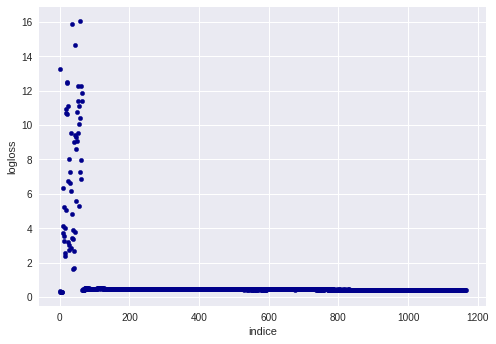

In [81]:
ax1 = scores.plot.scatter(y='logloss',x='indice',c='DarkBlue')

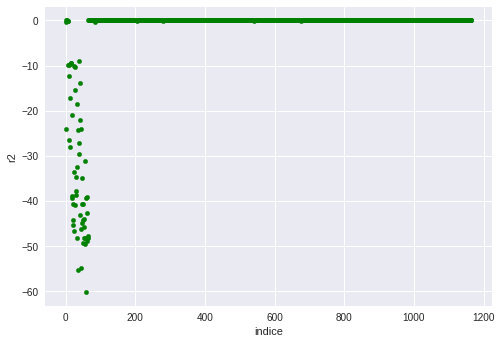

In [82]:
ax1 = scores.plot.scatter(y='r2',x='indice',c='green')

In [112]:
ax1 = scores.plot.scatter(y='accuracy',x='indice',c='green')

AttributeError: ignored

In [0]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB( fit_prior=True, class_prior=None)

In [0]:

df = train
nicial=-1
paso=2000
scores=[]

for n in range(1,df.shape[0]-1,paso):
  nicial=nicial+paso
  #print(n-1,nicial)
  X=train.iloc[n-1:nicial,1:]
  Yt=train.iloc[n-1:nicial,:].Label
  dictX = X[X.columns].to_dict(orient='records')
  try:
    Xt = vec.fit_transform(dictX)
   
    clf.partial_fit(Xt,Yt,classes=np.unique(Yt));
    ypred = clf.predict_proba(Xttest)
    #print(clf2.score(Xttest,Ytest))
    scores.append([clf.score(Xttest,Ytest),r2_score(Ytest, ypred[:, 1]),log_loss(Ytest, ypred[:, 1])] )
  except Exception as e :
    #pass
    print (str(e))#print(dictX)#Y=df.iloc[n-1:nicial,:].Label
  #clf2.partial_fit(Xt, Y, classes=np.unique(Y))

  
  
  
  

In [0]:
scoresNB=pd.DataFrame(scores,columns=['accuracy','r2','logloss'])
scoresNB['indices']=scoresNB.index


In [106]:
scoresNB.describe()

,accuracy,r2,logloss,indices
count,166.000000,166.000000,166.000000,166.000000
mean,0.805925,-9.327882,0.717017,82.500000
std,0.061758,3.240323,0.159730,48.064193
min,0.735918,-12.972934,0.227102,0.000000
25%,0.767984,-11.248373,0.671676,41.250000
50%,0.791655,-10.100671,0.728950,82.500000
75%,0.812943,-9.115305,0.838180,123.750000
max,0.984104,-0.016153,0.942872,165.000000


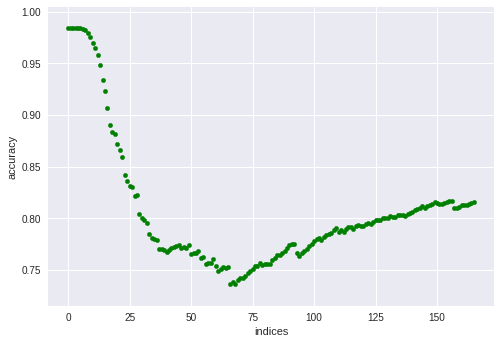

In [114]:
ax1 = scoresNB.plot.scatter(y='accuracy',x='indices',c='green')

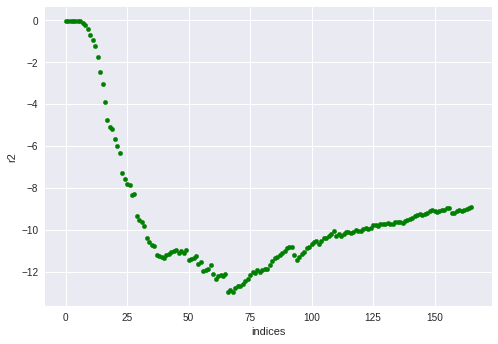

In [109]:
ax1 = scoresNB.plot.scatter(y='r2',x='indices',c='green')

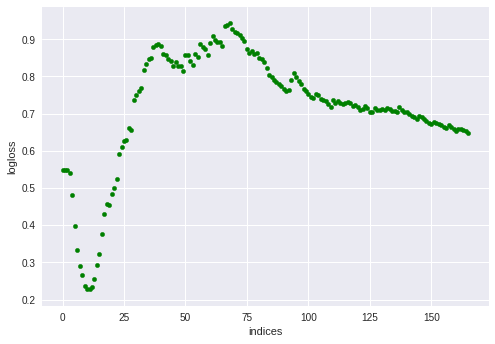

In [110]:
ax1 = scoresNB.plot.scatter(y='logloss',x='indices',c='green')

In [0]:
y_train=getDfFeatures(train)
x_train=getDfLabels(train)

In [0]:
##Listamos las columnas por tipo
#g = df.columns.to_series().groupby(df.dtypes).groups

    

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler

class MyScaler(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    #self.scaler = MinMaxScaler()
    self.scaler = StandardScaler()
    self.scaler.fit(X[self.cols])
    return self

  def transform(self, X):
    return self.scaler.transform(X[self.cols])

In [0]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import HashingVectorizer

class MyVectorizer(BaseEstimator, TransformerMixin):
  
  def __init__(self, cols, hashing=None):
    """
    args:
    cols: a list of column names of the categorical variables
    hashing: 
    If None, then vectorization is a simple one-hot-encoding.
    If an integer, then hashing is the number of features in the output.
        """
    self.cols = cols
    self.hashing = hashing

  def fit(self, X, y=None):

    data = X[self.cols]

    # Choose a vectorizer
    if self.hashing is None:
        self.myvec = HashingVectorizer()
    else:
        #self.myvec = FeatureHasher(n_features = self.hashing)
        self.myvec = FeatureHasher(n_features = self.hashing, non_negative=True)

    self.myvec.fit(X[self.cols].to_dict(orient='records'))
    return self

  def transform(self, X):

    # Vectorize Input
    if self.hashing is None:
        return pd.DataFrame(
            self.myvec.transform(X[self.cols].to_dict(orient='records')),
            columns = self.myvec.feature_names_
        )
    else:
        return pd.DataFrame(
            self.myvec.transform(X[self.cols].to_dict(orient='records')).toarray()
        )

In [0]:
search_params = {
    'preprocess__vectorize__hashing': [20, 40, 80],
    'predict__alpha': [.01, .1, 1, 2, 10]
}

In [0]:
numeric_predictors=['auction_age', 'auction_bidfloor']

In [0]:
categorical_predictors=['action_categorical_0', 'action_categorical_1', 'action_categorical_2',
        'action_categorical_3', 'action_categorical_4', 'action_categorical_5',
        'action_categorical_6', 'action_categorical_7', 'action_list_0',
        'action_list_1', 'action_list_2', 'auction_boolean_0',
        'auction_boolean_1', 'auction_boolean_2', 'auction_categorical_0',
        'auction_categorical_1', 'auction_categorical_10',
        'auction_categorical_11', 'auction_categorical_12',
        'auction_categorical_2', 'auction_categorical_3',
        'auction_categorical_4', 'auction_categorical_5',
        'auction_categorical_6', 'auction_categorical_7',
        'auction_categorical_8', 'auction_categorical_9', 'auction_list_0',
        'creative_categorical_0', 'creative_categorical_1',
        'creative_categorical_10', 'creative_categorical_11',
        'creative_categorical_12', 'creative_categorical_2',
        'creative_categorical_3', 'creative_categorical_4',
        'creative_categorical_5', 'creative_categorical_6',
        'creative_categorical_7', 'creative_categorical_8',
        'creative_categorical_9', 'device_id_type', 'gender','creative_height']

In [0]:
otros = ['auction_time','creative_height','timezone_offset', 'creative_width']

In [0]:
#!pip install scikit-learn==0.20.0
!pip install utils
 

In [0]:
import operator
from functools import reduce
from itertools import product as iproduct
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


def product(iterable, start=1):
    return reduce(operator.mul, iterable, start)


class PolyDictVectorizer(DictVectorizer):

    def __init__(self, degree=2, sparse=True, num_types=[float]):
        self.degree = degree
        self.num_types = num_types
        super().__init__(sparse=sparse)

    def fit(self, X, y=None):
        ###agregado por mi para transformar el df a diccionario.
        X = X.to_dict(orient='records')
        return super().fit(map(self._encode, X), y)

    def _transform(self, X, fitting):
        return super()._transform(map(self._encode, X), fitting)

    def _encode(self, dic):
        dic = {k if type(v) in self.num_types else f'{k}={v}':
               float(v) if type(v) in self.num_types else 1
               for k, v in dic.items()}
        dic_keys = list(dic.keys())
        for deg in range(2, self.degree + 1):
            for term_keys in iproduct(dic_keys, repeat=deg):
                term_names, term_facts = [], []
                for k, n in Counter(term_keys).items():
                    v = dic[k]
                    if type(v) is int and n > 1:
                        break
                    term_names.append(k if n == 1 else f'{k}^{n}')
                    term_facts.append(v**n)
                else:  # No dummy feature was included more than once
                    dic['*'.join(sorted(term_names))] = product(term_facts)
        return dic



In [0]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import Imputer

pipeline = Pipeline([
    ('preprocess', FeatureUnion([
        #('imp', Imputer(strategy='most_frequent', axis=0)),
        #('scale', MyScaler(cols=numeric_predictors)),
        #('vectorize', MyVectorizer(cols=categorical_predictors, hashing=5))
        ('poly',PolyDictVectorizer())
    ])),
    ('predict', SGDClassifier())
])

In [0]:
x = pipeline.fit(y_train)

In [0]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipeline, search_params)
grid_search.fit(x_train,y_train)

In [0]:
SGDClassifier()
import numpy as np
# SGD mini-batch
# Get num training samples
df_train=df
N_train = len(df_train)
num_passes = 50
output='Label'
batch_size = N_train
model = sklearn.linear_model.SGDClassifier(loss= 'log', alpha = 1, tol = 0.00001, shuffle = False, random_state = 0)
# Set 80% of data to belong to training set; reserve the rest for validation set
train_indices = list(range(int(0.8*N_train)))
valid_indices = list(range(int(0.8*N_train), N_train))

sgd_minibatch_scores = []
for i in range(num_passes):
    np.random.shuffle(train_indices)
    for j in range(int(len(train_indices)/batch_size + 1)):

        if j == int(len(train_indices)/batch_size+1):
            batch_train_indices = train_indices[j*batch_size:]
        else:
            batch_train_indices = train_indices[j*batch_size:(j+1)*batch_size]

        model.partial_fit(df_train.iloc[batch_train_indices], df_train[output].iloc[batch_train_indices], classes = [0,1],)

    sgd_minibatch_scores.append(model.score(df_train.iloc[valid_indices], df_train[output].iloc[valid_indices]))


In [0]:
vec = PolyDictVectorizer()

for i in range(0,len(df),1000):
  limiteSup = i + 1000
  dfChunk = df.iloc[i:limiteSup]
  features =getDfFeatures(dfChunk)
  labels = getDfLabels(dfChunk)
  dictFeat=features.to_dict(orient='records')
   vec.fit(dictFeat)
  

In [0]:
###NO FUNCIONA.


In [0]:
vec

In [0]:
dfFull  =  pd.concat([pd.read_csv(zipfile.ZipFile('ctr_15.zip').open('ctr_15.csv')), pd.read_csv(zipfile.ZipFile('ctr_16.zip').open('ctr_16.csv')),pd.read_csv(zipfile.ZipFile('ctr_17.zip').open('ctr_17.csv')),pd.read_csv(zipfile.ZipFile('ctr_18.zip').open('ctr_18.csv')),pd.read_csv(zipfile.ZipFile('ctr_19.zip').open('ctr_19.csv')),pd.read_csv(zipfile.ZipFile('ctr_20.zip').open('ctr_20.csv')), pd.read_csv(zipfile.ZipFile('ctr_21.zip').open('ctr_21.csv'))],axis=0)


In [0]:
##tamaño del df en GB
import sys
dfFull.memory_usage(index=True).sum()/1000000000 #giga
#float(sys.getsizeof(dfFull)) 


In [0]:
%reset dfFull

In [0]:
dict=dfFull.to_dict()


In [0]:
dfFull.sample(10)

In [0]:
dfFull.shape